# McDonald's Basket Data Analysis - Clustering v1
## April 2018
### Dr Jose M Albornoz

This notebook performs a clustering analysis for the basket items found in data for all 7 Reading areas stores during September 2017

# 1.- Import necessary modules, define SQLContext

In [2]:
# Import required modules
import pandas as pd
import numpy as np

from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.preprocessing import StandardScaler

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import style
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
style.use('fivethirtyeight')
%matplotlib inline

import datetime

In [3]:
pd.set_option('display.height', 1000)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# 2.- Load basket data

In [4]:
column_labels = ['store_number', 'time_period', 'time_of_day', 'business_date', 'pos_code', 'c6', 'total_cost', \
                 'unit_cost', 'quantity', 'food_cost', 'paper_cost', 'hour', 'transaction_time', 'transaction_date', \
                 'pos_id', 'unique_till_code', 'sale_number', 'menu_item_id', 'till_key', 'channel', 'c20', \
                 'sale_or_refund', 'eatin_eatout', 'eat_in_eatout_str', 'payment_type_id', 'payment_type']

In [5]:
df_basket1 = pd.read_csv("BasketDataReading7Sept_not15/000", names=column_labels, sep='|')

In [6]:
df_basket1.shape

(1278812, 26)

In [7]:
df_basket1.head()

,store_number,time_period,time_of_day,business_date,pos_code,c6,total_cost,unit_cost,quantity,food_cost,paper_cost,hour,transaction_time,transaction_date,pos_id,unique_till_code,sale_number,menu_item_id,till_key,channel,c20,sale_or_refund,eatin_eatout,eat_in_eatout_str,payment_type_id,payment_type
0,787,5,Evening,2017-09-17,2,NaN,0.74,0.74,1,0.0955,0.0033,21,2017-09-17 21:05:33,2017-09-17,POS0002:947136517,947136517,1,4800,1,FRONT COUNTER,1,Sale,0,Take Out,1,Cash
1,787,4,Dinner,2017-09-17,2,NaN,0.20,0.20,1,0.1554,0.0000,19,2017-09-17 19:34:03,2017-09-17,POS0002:947136508,947136508,1,4630,1,FRONT COUNTER,1,Sale,0,Take Out,1,Cash
2,787,2,Lunch,2017-09-17,20,NaN,0.77,0.77,1,0.0612,0.0325,13,2017-09-17 13:24:39,2017-09-17,POS0019:1051702100,1051702100,6,3025,2,DRIVE THRU,1,Sale,0,Take Out,1,Cash
3,787,2,Lunch,2017-09-17,20,NaN,0.00,0.00,1,0.0000,0.0000,13,2017-09-17 13:24:39,2017-09-17,POS0019:1051702100,1051702100,5,4833,2,DRIVE THRU,1,Sale,0,Take Out,1,Cash
4,787,2,Lunch,2017-09-17,20,NaN,2.97,2.97,1,0.4751,0.0348,13,2017-09-17 13:24:39,2017-09-17,POS0019:1051702100,1051702100,1,6150,2,DRIVE THRU,1,Sale,0,Take Out,1,Cash


In [8]:
df_basket1['time_of_day'].unique()

array(['Evening', 'Dinner', 'Lunch', 'Afternoon', 'Breakfast', 'Night'],
      dtype=object)

In [9]:
df_basket1['time_period'].unique()

array([5, 4, 2, 3, 1, 6])

## 2.1.- Convert transaction_time to datetime

In [10]:
df_basket1['transaction_time'] = pd.to_datetime(df_basket1['transaction_time'])

## 2.2.- Filter data by range of days

In [11]:
df_basket2 = df_basket1[(df_basket1['transaction_time'] >= datetime.date(2017,9,1)) & \
                         (df_basket1['transaction_time'] <= datetime.date(2017,9,5))]

In [12]:
df_basket2.shape

(218408, 26)

# 3.- Preprocessing

In [13]:
df_basket3 = df_basket2[['store_number', 'time_period', 'eatin_eatout', 'payment_type_id', \
                         'channel', 'menu_item_id', 'unit_cost']]

In [14]:
df_basket3.head()

,store_number,time_period,eatin_eatout,payment_type_id,channel,menu_item_id,unit_cost
573559,1262,2,0,2,DRIVE THRU,1146,1.24
573560,1262,2,0,2,DRIVE THRU,4834,0.00
573561,1262,2,0,2,DRIVE THRU,4903,1.33
573562,1262,2,0,2,DRIVE THRU,3030,1.01
573563,1262,2,0,2,DRIVE THRU,6120,3.07


In [15]:
df_basket3['unit_cost'].unique()

array([ 1.24,  0.  ,  1.33,  1.01,  3.07,  0.59,  1.57,  2.97,  0.71,
        1.66,  0.77,  3.33,  0.49,  0.2 , -0.62, -0.5 ,  0.82,  3.43,
        3.01,  2.19,  0.83,  0.91,  1.99,  3.41,  1.07, -0.52,  2.99,
        0.87,  2.95,  2.93,  3.49,  2.49,  1.62,  2.31,  3.38,  1.11,
        0.74,  0.17,  1.16,  2.83,  4.48,  1.85,  0.16,  4.46,  4.29,
       -0.42,  2.07,  1.41, -0.48,  2.74,  1.63,  4.65,  0.62,  2.96,
        1.59,  0.9 , -0.4 ,  2.16, -0.46,  2.28,  1.15,  4.56,  1.02,
        2.41,  3.37,  1.38,  3.84, -0.7 ,  0.25,  4.07,  3.93,  2.57,
       -0.33,  2.12,  4.6 ,  1.06, -0.82,  3.15,  3.16,  0.66,  1.19,
        1.67,  3.1 ,  1.2 , -0.68,  3.83,  3.17, -0.55,  4.45,  1.45,
        1.69,  1.91,  1.49,  3.  ,  0.58,  1.81,  0.19,  3.97,  0.97,
        3.11,  4.5 ,  3.7 ,  1.74,  2.  ,  3.29,  0.13,  1.39,  1.34,
       -0.45,  3.24,  3.14,  1.56,  3.53,  2.17, -0.43,  1.84,  0.14,
        1.51,  4.4 ,  2.33,  3.02,  4.52,  0.99,  3.64,  3.72,  4.26,
        1.89,  2.08,

In [16]:
len(df_basket3['unit_cost'].unique())

282

## 3.1.- Exclude items with zero or negative cost

In [17]:
df_basket3 = df_basket3[(df_basket3['unit_cost'] != 0) & (df_basket3['unit_cost'] >= 0)]

In [18]:
df_basket3['unit_cost'].unique()

array([1.24, 1.33, 1.01, 3.07, 0.59, 1.57, 2.97, 0.71, 1.66, 0.77, 3.33,
       0.49, 0.2 , 0.82, 3.43, 3.01, 2.19, 0.83, 0.91, 1.99, 3.41, 1.07,
       2.99, 0.87, 2.95, 2.93, 3.49, 2.49, 1.62, 2.31, 3.38, 1.11, 0.74,
       0.17, 1.16, 2.83, 4.48, 1.85, 0.16, 4.46, 4.29, 2.07, 1.41, 2.74,
       1.63, 4.65, 0.62, 2.96, 1.59, 0.9 , 2.16, 2.28, 1.15, 4.56, 1.02,
       2.41, 3.37, 1.38, 3.84, 0.25, 4.07, 3.93, 2.57, 2.12, 4.6 , 1.06,
       3.15, 3.16, 0.66, 1.19, 1.67, 3.1 , 1.2 , 3.83, 3.17, 4.45, 1.45,
       1.69, 1.91, 1.49, 3.  , 0.58, 1.81, 0.19, 3.97, 0.97, 3.11, 4.5 ,
       3.7 , 1.74, 2.  , 3.29, 0.13, 1.39, 1.34, 3.24, 3.14, 1.56, 3.53,
       2.17, 1.84, 0.14, 1.51, 4.4 , 2.33, 3.02, 4.52, 0.99, 3.64, 3.72,
       4.26, 1.89, 2.08, 1.9 , 3.34, 3.48, 2.24, 1.7 , 1.61, 1.65, 1.82,
       0.09, 3.71, 2.91, 3.91, 1.83, 2.66, 0.57, 3.52, 0.21, 0.23, 4.43,
       1.29, 4.35, 2.22, 2.79, 2.23, 4.28, 3.05, 4.57, 3.57, 1.64, 4.64,
       4.3 , 0.41, 0.4 , 1.35, 2.13, 2.87, 4.02, 2.

In [19]:
len(df_basket3['unit_cost'].unique())

245

In [20]:
len(df_basket3['menu_item_id'].unique())

473

In [21]:
df_basket3.shape

(141446, 7)

## 3.1.- Encode channel

In [22]:
df_basket3['channel'].unique()

array(['DRIVE THRU', 'FRONT COUNTER', 'KIOSK'], dtype=object)

In [23]:
channel_mapping = {label:idx for idx,label in enumerate(np.unique(df_basket3['channel']))}

In [24]:
channel_mapping

{'DRIVE THRU': 0, 'FRONT COUNTER': 1, 'KIOSK': 2}

In [25]:
df_basket3['channel'] = df_basket3['channel'].map(channel_mapping)

In [26]:
df_basket3.head()

,store_number,time_period,eatin_eatout,payment_type_id,channel,menu_item_id,unit_cost
573559,1262,2,0,2,0,1146,1.24
573561,1262,2,0,2,0,4903,1.33
573562,1262,2,0,2,0,3030,1.01
573563,1262,2,0,2,0,6120,3.07
573565,102,5,0,1,1,4903,1.33


## 3.2.- Encoding summary

time_of_day: 

* 1 for breakfast 
* 2 for lunch
* 3 for afternoon
* 4 for dinner 
* 5 for evening
* 6 for night
             
eatin_eatout: 
* 0 for take-out 
* 1 for eat-in             

payment_type_id: 
* 1 for cash 
* 2 for cashless

channel: 
* 0 for drive-thru 
* 1 for front counter 
* 2 for kiosk 
* 3 for mobile

# 4.- Feature selection

In [27]:
# df_basket2 = df_basket1[['time_period', 'eatin_eatout', 'payment_type_id', \
#                          'channel', 'menu_item_id', 'unit_cost']]

In [28]:
#df_basket4 = df_basket3[['time_period', 'eatin_eatout']]

In [29]:
df_basket4 = df_basket3[['time_period', 'unit_cost']]

# 5.- Clustering

## 5.1.- Scaling 

In [30]:
X_raw = df_basket4.values

In [31]:
X_raw

array([[2.  , 1.24],
       [2.  , 1.33],
       [2.  , 1.01],
       ...,
       [2.  , 0.59],
       [2.  , 1.57],
       [2.  , 1.07]])

In [32]:
X = StandardScaler().fit_transform(X_raw)

## 5.2.- Running DBSCAN

In [33]:
db = DBSCAN(eps=0.10, min_samples=100).fit(X)

In [34]:
# create an array of zeros with the same lenght of the cluster labels
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)

In [35]:
# sets mask values to True
core_samples_mask[db.core_sample_indices_] = True

In [36]:
labels = db.labels_

In [37]:
# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

In [38]:
print('Estimated number of clusters: %d' % n_clusters_)

Estimated number of clusters: 16


# 6.- Visualisation

Text(0,0.5,'Item cost, £')

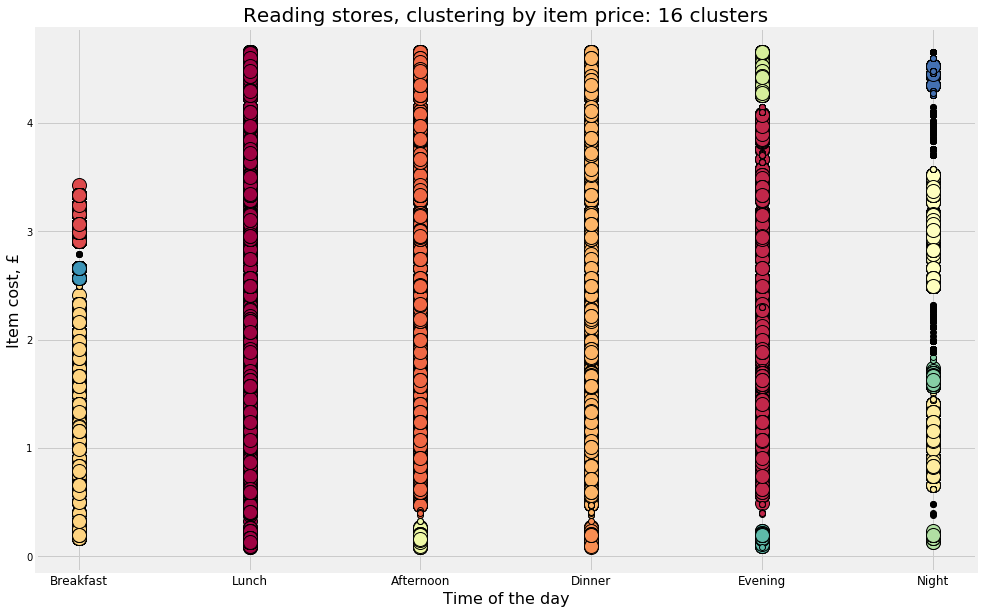

In [39]:
fig, ax = plt.subplots(figsize=(15, 10))

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]

for k, col in zip(unique_labels, colors):
    
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)
    
    xy = X_raw[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col), markeredgecolor='k', markersize=14)

    xy = X_raw[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col), markeredgecolor='k', markersize=6)

plt.title('Reading stores, clustering by item price: %d clusters' % n_clusters_, fontsize=20)
plt.xlabel('Time of the day', fontsize=16)
x_labels = ['', 'Breakfast', 'Lunch', 'Afternoon', 'Dinner', 'Evening', 'Night']
ax.set_xticklabels(x_labels, fontsize=12)
plt.ylabel('Item cost, £', fontsize=16)
#plt.savefig('clusterByPrice.png', dpi=150)

In [40]:
unique_labels

{-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15}

# 7.- Menu item identification

## 7.1.- Read menu item data

In [41]:
df_menu = pd.read_csv('other_datasets/MenuItemGroupsOrdered.csv')

In [42]:
df_menu.head(5)

,1046,1955,1955 ALC,Promo Sandwiches ALC,Promo Sandwiches ALC.1,Promo Sandwiches ALC.2,Sandwiches ALC,Sandwiches ALC.1,Premium,Premium.1,Beef,1955.1,Promotional Beef ALC,Premium.2,Promo ALC and EVMs,Promo ALC and EVMs.1,Promotional Food,No Voucher
0,1047,LSM-BOGOF HAM,Hamburger ALC,Core Sandwiches ALC,Core Sandwiches ALC,Core Sandwiches ALC,Sandwiches ALC,Sandwiches ALC,Core ALC Food,Core ALC Food,Beef,Hamburger,Hamburger ALC,Core ALC Food,Core ALC and EVMs,Core ALC and EVMs,Permanent Food,LSM
1,1048,LSM-BOGOF MAYO LEGND,Chicken Legend with Cool Mayo ALC,Premium Sandwiches ALC,Premium Sandwiches ALC,Premium Sandwiches ALC,Sandwiches ALC,Sandwiches ALC,Premium,Premium,Chicken,Chicken Legend with Cool Mayo,Chicken Legend with Cool Mayo ALC,Premium,Permanent Premium ALC and EVMs,Permanent Premium ALC and EVMs,Permanent Food,LSM
2,1049,LSM-BOGOF SALS LEGND,Chicken Legend with Salsa ALC,Premium Sandwiches ALC,Premium Sandwiches ALC,Premium Sandwiches ALC,Sandwiches ALC,Sandwiches ALC,Premium,Premium,Chicken,Chicken Legend with Salsa,Chicken Legend with Salsa ALC,Premium,Permanent Premium ALC and EVMs,Permanent Premium ALC and EVMs,Permanent Food,LSM
3,1051,SPANISH,Spanish ALC,Promo Sandwiches ALC,Promo Sandwiches ALC,Promo Sandwiches ALC,Sandwiches ALC,Sandwiches ALC,Premium,Premium,Beef,Spanish,Promotional Beef ALC,Premium,Promo ALC and EVMs,Promo ALC and EVMs,Promotional Food,No Voucher
4,1052,AUSTRALIAN,Australian ALC,Promo Sandwiches ALC,Promo Sandwiches ALC,Promo Sandwiches ALC,Sandwiches ALC,Sandwiches ALC,Premium,Premium,Beef,Australian,Promotional Beef ALC,Premium,Promo ALC and EVMs,Promo ALC and EVMs,Promotional Food,No Voucher


In [43]:
df_menu.dtypes

1046                       int64
1955                      object
1955 ALC                  object
Promo Sandwiches ALC      object
Promo Sandwiches ALC.1    object
Promo Sandwiches ALC.2    object
Sandwiches ALC            object
Sandwiches ALC.1          object
Premium                   object
Premium.1                 object
Beef                      object
1955.1                    object
Promotional Beef ALC      object
Premium.2                 object
Promo ALC and EVMs        object
Promo ALC and EVMs.1      object
Promotional Food          object
No Voucher                object
dtype: object

In [44]:
df_menu['1046'] = df_menu['1046'].astype(str).astype(int)

## 7.2.- Consider items not sold at night-time

In [45]:
df_night_items = df_basket3[df_basket3['time_period'] == 6]

In [46]:
df_night_items.shape

(5956, 7)

In [47]:
night_items = df_night_items['menu_item_id'].unique()

In [48]:
len(night_items)

283

In [49]:
all_items = df_basket3['menu_item_id'].unique()

In [50]:
len(all_items)

473

In [51]:
not_sold_at_night = set(all_items) - set(night_items)

In [52]:
len(not_sold_at_night)

190

In [53]:
df_not_sold_at_night = df_menu[df_menu['1046'].isin(not_sold_at_night)]

In [54]:
df_not_sold_at_night.head()

,1046,1955,1955 ALC,Promo Sandwiches ALC,Promo Sandwiches ALC.1,Promo Sandwiches ALC.2,Sandwiches ALC,Sandwiches ALC.1,Premium,Premium.1,Beef,1955.1,Promotional Beef ALC,Premium.2,Promo ALC and EVMs,Promo ALC and EVMs.1,Promotional Food,No Voucher
180,2252,WRAP M CHILLI GRL,Grilled Sweet Chilli Chicken Wrap Medium EVM,Wraps Medium EVM,Wraps Medium EVM,Deli Choices Medium EVMs,Deli Choices EVM,Total EVMs,Deli Choices,Deli Choices,Chicken,Wrap - Grilled Sweet Chilli Chicken,Wrap - Grilled Sweet Chilli Chicken,Deli Choices,Deli ALC and EVMs (Perm. and Promo),Deli ALC and EVMs (Perm. and Promo),Permanent Food,No Voucher
181,2253,WRAP M CHILI GR(WOD),Grilled Sweet Chilli Chicken Wrap Medium EVM,Wraps Medium EVM,Wraps Medium EVM,Deli Choices Medium EVMs,Deli Choices EVM,Total EVMs,Deli Choices,Deli Choices,Chicken,Wrap - Grilled Sweet Chilli Chicken,Wrap - Grilled Sweet Chilli Chicken,Deli Choices,Deli ALC and EVMs (Perm. and Promo),Deli ALC and EVMs (Perm. and Promo),Permanent Food,Of the Day
183,2255,WRAP L CHILI GR(WOD),Grilled Sweet Chilli Chicken Wrap Large EVM,Wraps Large EVM,Wraps Large EVM,Deli Choices Large EVMs,Deli Choices EVM,Total EVMs,Deli Choices,Deli Choices,Chicken,Wrap - Grilled Sweet Chilli Chicken,Wrap - Grilled Sweet Chilli Chicken,Deli Choices,Deli ALC and EVMs (Perm. and Promo),Deli ALC and EVMs (Perm. and Promo),Permanent Food,Of the Day
184,2256,M EMP WRP CHILLI GRL,Grilled Sweet Chilli Chicken Wrap Medium EVM,Wraps Medium EVM,Wraps Medium EVM,Deli Choices Medium EVMs,Deli Choices EVM,Total EVMs,Deli Choices,Deli Choices,Chicken,Wrap - Grilled Sweet Chilli Chicken,Wrap - Grilled Sweet Chilli Chicken,Deli Choices,Deli ALC and EVMs (Perm. and Promo),Deli ALC and EVMs (Perm. and Promo),Permanent Food,Employee Meal
189,2261,WRAP M PIRI GRL(WOD),Grilled Peri Peri Chicken Wrap Medium EVM,Wraps Medium EVM,Wraps Medium EVM,Deli Choices Medium EVMs,Deli Choices EVM,Total EVMs,Deli Choices,Deli Choices,Chicken,Wrap - Grilled Peri Peri Chicken,Wrap - Grilled Peri Peri Chicken,Deli Choices,Deli ALC and EVMs (Perm. and Promo),Deli ALC and EVMs (Perm. and Promo),Permanent Food,Of the Day
